In [184]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

Local Polynomial Approximation
-------------------------------
Set the parameters

In [185]:
# # maximum degree of polynomial used for fitting
# N = 2

# # filter size
# M = 51

# large M, small N -> a lot of bias when frequency increases
N = 2
M = 53

# large M, large N -> smaller bias than before, but a lot of variance in smooth regions
# N = 7
# M = 51

# small M, small N -> smaller bias everywhere, higher variance
# N = 2
# M = 5

# M small, M = N,  -> smaller bias than before, higher variance than before
# N = 5
# M = N

Generate synthetic signal signal

In [186]:
LENGHT = 1000

ty = np.linspace(0, 1, LENGHT)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.1

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)


Text(0.5, 1.0, 'Input Signal')

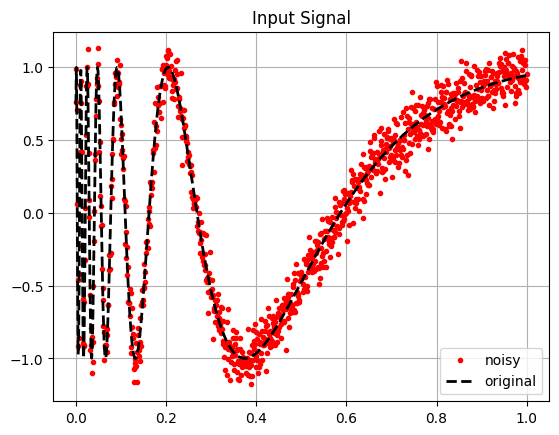

In [187]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window


In [188]:
t = np.arange(0, 0.5*M, 0.5) # to avoid integer limit
T = np.zeros((M, N+1))
for i in range(N+1):
    T[:, i] = t ** i

In [189]:
T.shape

(53, 3)

Look at the matrix T, the columns correspond to polynomials sampled over the interval [0,1]


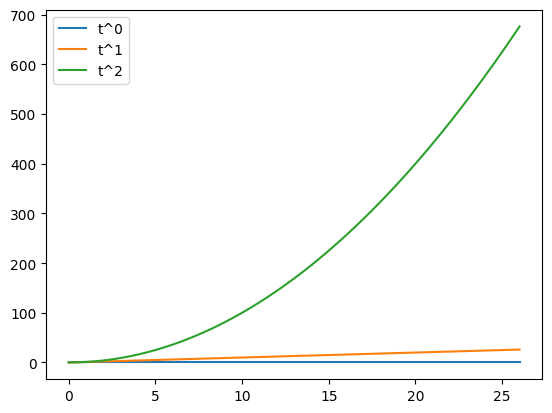

In [190]:
plt.figure()
leg = []
for l in range(N+1):
    plt.plot(t, T[:, l])
    leg.append(f't^{l:d}')
plt.legend(leg)

Construct the LPA kernel

In [191]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(T)

In [192]:
Q.shape[0]

53

In [193]:
# select the central row of Q
row = Q[Q.shape[0]//2,:] 

# compute the kernel
if N == M:
    g = [row[i] * Q[:,i] for i in range(N)]
else:
    g = [row[i] * Q[:,i] for i in range(N+1)] # row[i] = Q(i,c) where c is the center of Q ^^
g = sum(g) # row[i] = Q(i,c) where c is the center of Q ^^

# flipping, since it is used in convolution
g = np.flip(g)

Text(0.5, 1.0, 'M = 53, N = 2')

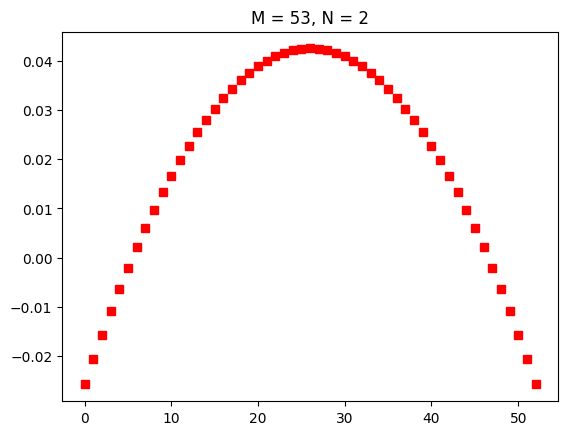

In [194]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'M = {M:d}, N = {N:d}')


Filtering

In [195]:
shat = convolve(s, g, 'same')

In [196]:
shat.shape 

(1000,)

Text(0.5, 1.0, 'M = 53, N = 2')

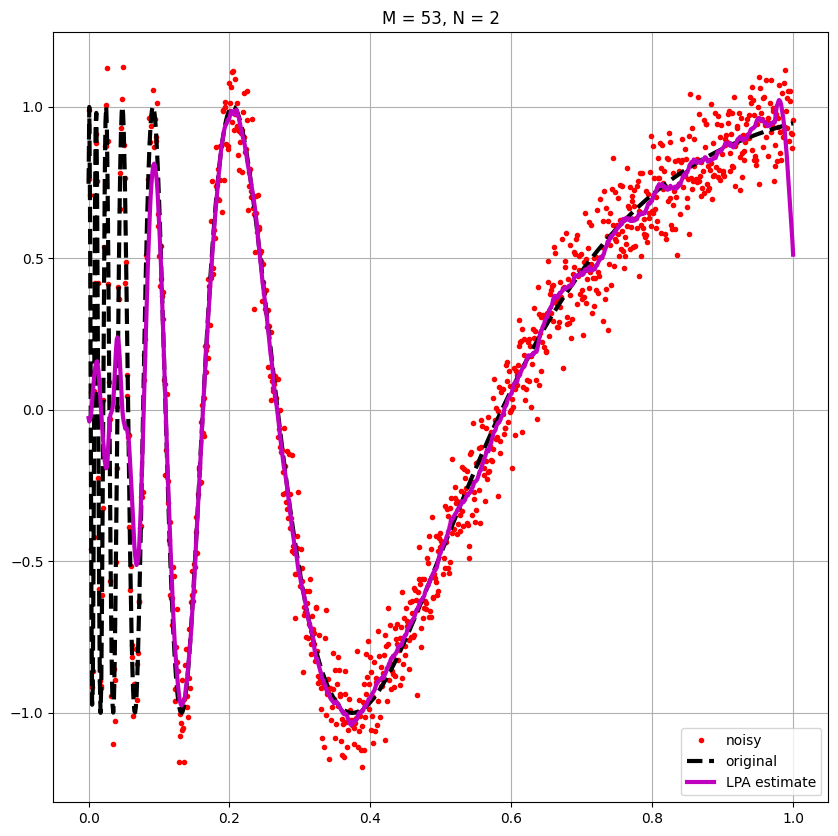

In [197]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')


Weighted LPA
--------------
Set the parameters

In [198]:
# This part is redefining constants above, ignore
# # maximum degree of polynomial used for fitting
# N = 1

# # filter size
# M = 53

# half filter size
HFS = int((M-1)/2)

# set the weights. Here weights simply define the window size
w = np.zeros(M)

# centered kernel
wc = w.copy()
wc[int(HFS/2):-int(HFS/2)] = 1

# left kernel
wl = w.copy()
wl[:HFS+1] = 1

# right kernel
wr = w.copy()
wr[-HFS-1:] = 1


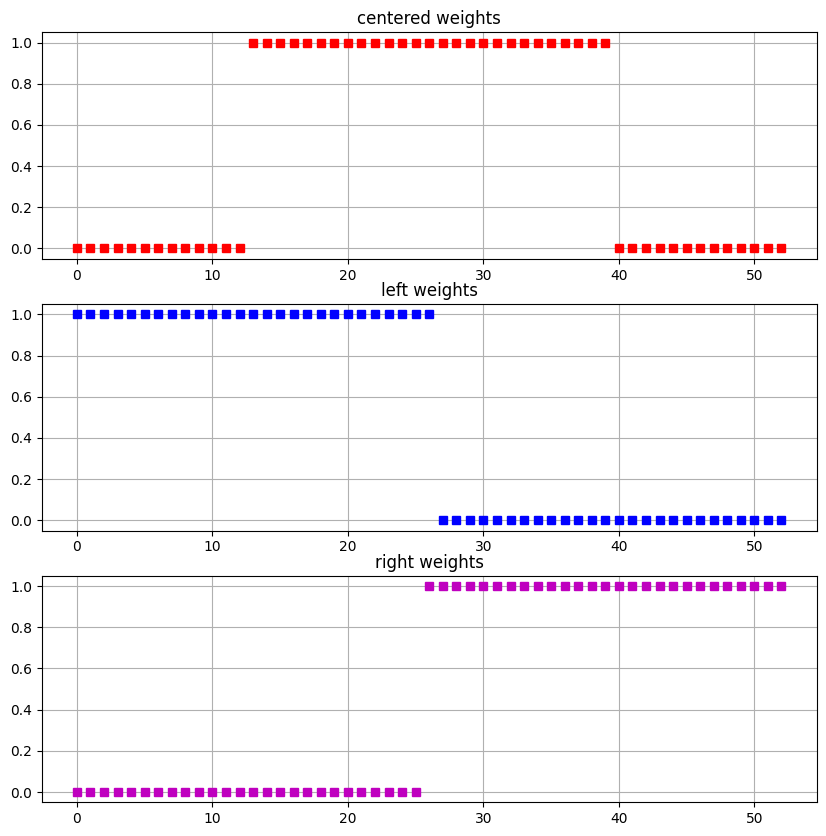

In [199]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(wc, 'rs', linewidth=3)
ax[0].set_title('centered weights')
ax[0].grid()
ax[1].plot(wl, 'bs', linewidth=3)
ax[1].set_title('left weights')
ax[1].grid()
ax[2].plot(wr, 'ms', linewidth=3)
ax[2].set_title('right weights')
ax[2].grid()


Build the weight matrix

In [200]:
# select a single weight to be used in what follows
w = wr

# generate the inverse of weights
winv = 1/w # np.linalg.inv doesnt work for 1-dimension arrays

# set to zero weights that are inf
winv = np.where(np.isinf(winv), 0, winv)

# define the weight matrix
W = np.diag(w)
Winv = np.diag(winv) # can't do np.linalg.inv(W) because W is Singular

C:\Users\Angela\AppData\Local\Temp\ipykernel_7700\2404755028.py:5: RuntimeWarning: divide by zero encountered in divide
  winv = 1/w # np.linalg.inv doesnt work for 1-dimension arrays


Generate synthetic signal signal

In [201]:
LENGHT = 1000

# clean signal
ty = np.linspace(0, 1, LENGHT)
y =  8*ty**2 - 2*ty + 2;
y[LENGHT//2 : LENGHT] = y[LENGHT//2 : LENGHT] + 7;

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)

Text(0.5, 1.0, 'Input Signal')

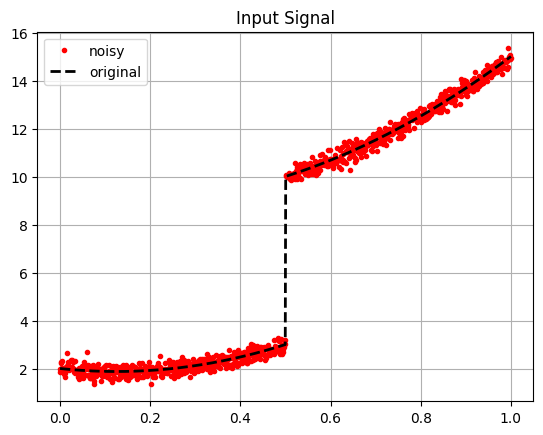

In [202]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window

In [203]:
t = np.arange(0, 0.5*M, 0.5) # to avoid integer limit
T = np.zeros((M, N+1))
for i in range(N+1):
    T[:, i] = t ** i

# # 0 order polynomial fit
# t = 1
# T = [t for i in range(M)]

Construct the LPA kernel

In [204]:
# compute the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(W@T)
# 0 order polynomial fit
# Q = [1/np.sqrt(M) for i in range(M)]

#  define Qtilde
Qtilde = Winv @ Q

# adjust Qtilde with the  weights matrix squared.
W2Qtilde = W**2 @ Qtilde

# select the central row of W2Qtilde
row = W2Qtilde[W2Qtilde.shape[0]//2,:] 

# compute the kernel
if N == M:
    g = [row[i] * W2Qtilde[:,i] for i in range(N)]
else:
    g = [row[i] * W2Qtilde[:,i] for i in range(N+1)] # row[i] = W2Qtilde(i,c) where c is the center of W2Qtilde ^^
g = sum(g)

# flipping, since it is used in convolution
g = np.flip(g)

Text(0.5, 1.0, 'filter M = 53, N = 2')

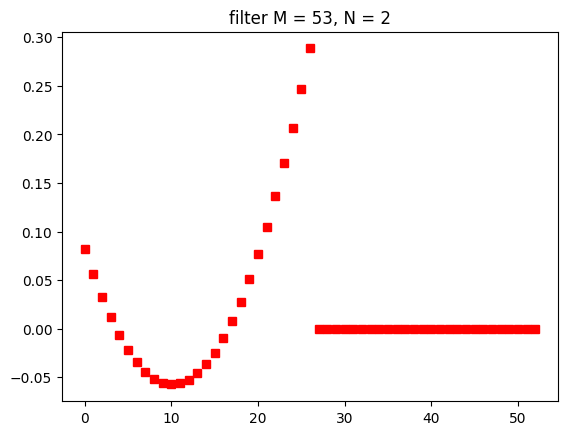

In [205]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'filter M = {M:d}, N = {N:d}')


Filtering


In [206]:
shat = convolve(s, g, 'same')

Text(0.5, 1.0, 'M = 53, N = 2')

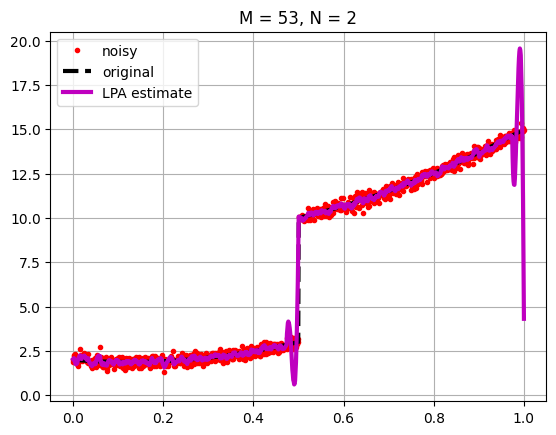

In [207]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')



Modify the code to use the central, left and right kernels